<a href="https://www.kaggle.com/mohamedahmedx2/using-ai-to-create-art-neural-style-transfer?scriptVersionId=90204880" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Neural Style transfer
NST was first introduced in 2015 [paper](https://arxiv.org/abs/1508.06576) it took advantage of how convolution neural network works, The system uses neural representations to separate and recombine content and style of arbitrary images. In simple words, it transfer the style from one image to another and their weights. The results vary depending on style image and the content image. In this notebook, it is designed in a way where you can easily use the Neural Style transfer with your own images with minimum adjustments. *Toggle kitty mode in kaggle notebook for best performance.* 

# literature review

![VGG19](https://raw.githubusercontent.com/MightyStud/NST-AI-to-create-art/main/diagrams/VGGNet-architecture-19-edited.png)
Using VGG19 network with pretrained weights excluding the top fully connected layers, usually for training purposes the weights of different layers are adjusting to minimize the loss function, however in NST, all the layers are frozen(not changed) except the input layer which in that case is the generated image.

The generated image is free to change its values to minimize the loss function.

How does the loss function look like in this case, you might ask? The loss function is combination of the content image loss and style image loss. The content loss compares the original image with the generated image for every convoloution layer. The style loss, on the other hand, uses the gram matrix to compare the style loss and the generated image loss.

More details are explained in the reserch paper.


# results:
The results will vary dramatically depending on the parameters you use, you can think of this as a filter for your images but with AI help rather than tools like photoshop.
![github image of result](https://github.com/MightyStud/NST-AI-to-create-art/blob/main/diagrams/0875.jpg?raw=true)

![github image of result 2](https://raw.githubusercontent.com/MightyStud/NST-AI-to-create-art/main/diagrams/showcase.png)

[timelapse video on youtube](https://youtu.be/S3XC1HuyxBQ)

# How to use:
1.  Upload the 2 folders, a content image folder and the style image folder with your images into your kaggle notebook by creating a new dataset 
2.  enter The name assoiated to your dataset in "name_of_your_dataset" variable
3.  modify the lines of code that has a comment that starts with "edit:" in config dictionary to fit your dataset
4. enable GPU acceleration and go wild

# Code

Importing librares 

In [1]:
import torch
from torch.optim import Adam, LBFGS
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms
import numpy as np
import os
import cv2 as cv
from collections import namedtuple
import matplotlib.pyplot as plt
import shutil

In [2]:
name_of_your_dataset = "project-data" # edit: enter the name of your dataset
folders = os.listdir(os.path.join("../input",name_of_your_dataset))
print("folders[0] is " ,folders[0],"\n folders[1] is ", folders[1])

folders[0] is  content-images 
 folders[1] is  style-images


In [3]:
default_resource_dir = os.path.join("../input",name_of_your_dataset)
content_images_dir = os.path.join(default_resource_dir, folders[0]) # edit: index of folders to fit your datasets
style_images_dir = os.path.join(default_resource_dir, folders[1]) # edit: index of folders to fit your datasets
output_img_dir = "./output-images/"
img_format = (4, '.jpg')  # saves images in the format: %04d.jpg

# Initializing the configuration options
for quick run, only edit the code cell below. However, I encourge you to dig deeper in the code to understand how it works :)

In [4]:
config = {
    "content_img_name":'pyramids3.jpg' , #edit: the name of the content image
    "style_img_name": "vg_starry_night.jpg", #edit: the name of style image
    "height" : 1080, #edit: image dimension can be increased however more time and meomory resoureses will be used
    "content_weight" : 1e5 , #edit: can be edited in an experimental way, default = 1e5 , for adam = 1e5 
    "style_weight" : 3e4, #edit: can be edited in an experimental way , default = 3e4 , for adam = 1e5
    "tv_weight" : 1e0, #edit: can be edited in an experimental way , default = 1e0, for adam = 1e-1
    "optimizer" : "lbfgs", #edit: adam or lbfgs, adam require less resources however need more epochs(iterations) to output good quality, lbfgs is the opposite(also it was used in the orignal paper) 
    "epochs" : 800, #edit: usually 2000 for adam, 800 for lbfgs can be experimented with
    "model" : 'vgg19',
    "init_method" :'content', #edit: can be edited in an experimental way, either 'random', 'content' or 'style'
    "saving_freq" : 200, #edit: note: -1 for only last output
    "content_images_dir" : content_images_dir,
    "style_images_dir" : style_images_dir,
    "output_img_dir" : output_img_dir,  
    "img_format" : img_format,
    "lr" : 5e0, #edit: defaults to 1e0 in lbfgs and 1e1 for adam
    "show_results" : True #edit: False or True to show each image after each save_freq
} 

# utilities

image manipulation 

In [5]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section, keeping aspect ratio of image intact 
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the height
            current_height, current_width = img.shape[:2]
            new_height = target_shape
            new_width = int(current_width * (new_height / current_height))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # this need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img

# normalize using ImageNet's mean
IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
IMAGENET_STD_NEUTRAL = [1, 1, 1]
def prepare_img(img_path, target_shape, device):
    img = load_image(img_path, target_shape=target_shape)

    
    # [0, 255] range worked much better for me than [0, 1] range (even though PyTorch models were trained on latter)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    img = transform(img).to(device).unsqueeze(0)

    return img


def save_image(img, img_path):
    if len(img.shape) == 2:
        img = np.stack((img,) * 3, axis=-1)
    cv.imwrite(img_path, img[:, :, ::-1])  # [:, :, ::-1] converts rgb into bgr (opencv contraint...)


def generate_out_img_name(config):
    prefix = os.path.basename(config['content_img_name']).split('.')[0] + '_' + os.path.basename(config['style_img_name']).split('.')[0]
    # called from the reconstruction script
    if 'reconstruct_script' in config:
        suffix = f'_o_{config["optimizer"]}_h_{str(config["height"])}_m_{config["model"]}{config["img_format"][1]}'
    else:
        suffix = f'_o_{config["optimizer"]}_i_{config["init_method"]}_h_{str(config["height"])}_m_{config["model"]}_cw_{config["content_weight"]}_sw_{config["style_weight"]}_tv_{config["tv_weight"]}{config["img_format"][1]}'
    return prefix + suffix


def save_and_maybe_display(optimizing_img, dump_path, config, img_id, num_of_iterations, should_display=False):
    saving_freq = config['saving_freq']
    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)  # swap channel from 1st to 3rd position: ch, _, _ -> _, _, chr

    # for saving_freq == -1 save only the final result (otherwise save with frequency saving_freq and save the last pic)
    if img_id == num_of_iterations-1 or (saving_freq > 0 and img_id % saving_freq == 0):
        img_format = config['img_format']
        out_img_name = str(img_id).zfill(img_format[0]) + img_format[1] if saving_freq != -1 else generate_out_img_name(config)
        dump_img = np.copy(out_img)
        dump_img += np.array(IMAGENET_MEAN_255).reshape((1, 1, 3))
        dump_img = np.clip(dump_img, 0, 255).astype('uint8')
        cv.imwrite(os.path.join(dump_path, out_img_name), dump_img[:, :, ::-1])
        if should_display:
            plt.imshow(np.uint8(get_uint8_range(out_img)))
            plt.show()


def get_uint8_range(x):
    if isinstance(x, np.ndarray):
        x -= np.min(x)
        x /= np.max(x)
        x *= 255
        return x
    else:
        raise ValueError(f'Expected numpy array got {type(x)}')

model initialization 

In [6]:
class Vgg19(torch.nn.Module):
    """
    Used in the original NST paper, only those layers are exposed which were used in the original paper

    'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1' were used for style representation
    'conv4_2' was used for content representation (although they did some experiments with conv2_2 and conv5_2)
    """
    def __init__(self, requires_grad=False, show_progress=False, use_relu=True):
        super().__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True, progress=show_progress).features
        if use_relu:  # use relu or as in original paper conv layers
            self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2', 'relu5_1']
            self.offset = 1
        else:
            self.layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']
            self.offset = 0
        self.content_feature_maps_index = 4  # conv4_2
        # all layers used for style representation except conv4_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))
        self.style_feature_maps_indices.remove(4)  # conv4_2

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        for x in range(1+self.offset):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(1+self.offset, 6+self.offset):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(6+self.offset, 11+self.offset):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(11+self.offset, 20+self.offset):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(20+self.offset, 22):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22, 29++self.offset):
            self.slice6.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out

call model

In [7]:
def prepare_model(model, device):
    # we are not tuning model weights -> we are only tuning optimizing_img's pixels! (that's why requires_grad=False)
    
    if model == 'vgg19':
        model = Vgg19(requires_grad=False, show_progress=True)
    #else: model == "Your model" #uncomment and experiment with another model

    content_feature_maps_index = model.content_feature_maps_index
    style_feature_maps_indices = model.style_feature_maps_indices
    layer_names = model.layer_names

    content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
    style_fms_indices_names = (style_feature_maps_indices, layer_names)
    return model.to(device).eval(), content_fms_index_name, style_fms_indices_names


def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram


def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

main script


In [8]:
def build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]

    current_set_of_feature_maps = neural_net(optimizing_img)

    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)

    style_loss = 0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    style_loss /= len(target_style_representation)

    tv_loss = total_variation(optimizing_img)

    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss

    return total_loss, content_loss, style_loss, tv_loss


def make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    # Builds function that performs a step in the tuning loop
    def tuning_step(optimizing_img):
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config)
        # Computes gradients
        total_loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss

    # Returns the function that will be called inside the tuning loop
    return tuning_step

In [9]:
def neural_style_transfer(config):
    content_img_path = os.path.join(config['content_images_dir'], config['content_img_name'])
    style_img_path = os.path.join(config['style_images_dir'], config['style_img_name'])

    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + os.path.split(style_img_path)[1].split('.')[0] + '_'+ str(config["height"])
    dump_path = os.path.join(config['output_img_dir'], out_dir_name)
    os.makedirs(dump_path, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = prepare_img(content_img_path, config['height'], device)
    style_img = prepare_img(style_img_path, config['height'], device)

    if config['init_method'] == 'random':
        # white_noise_img = np.random.uniform(-90., 90., content_img.shape).astype(np.float32)
        gaussian_noise_img = np.random.normal(loc=0, scale=90., size=content_img.shape).astype(np.float32)
        init_img = torch.from_numpy(gaussian_noise_img).float().to(device)
    elif config['init_method'] == 'content':
        init_img = content_img
    else:
        # init image has same dimension as content image - this is a hard constraint
        # feature maps need to be of same size for content image and init image
        style_img_resized = prepare_img(style_img_path, np.asarray(content_img.shape[2:]), device)
        init_img = style_img_resized

    # we are tuning optimizing_img's pixels! (that's why requires_grad=True)
    optimizing_img = Variable(init_img, requires_grad=True)

    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = prepare_model(config['model'], device)
    print(f'Using {config["model"]} in the optimization procedure.')

    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)

    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]

    # magic numbers in general are a big no no - some things in this code are left like this by design to avoid clutter
    num_of_iterations = {
        "lbfgs": config['epochs'],
        "adam": config['epochs'],
    }

    #
    # Start of optimization procedure
    #
    if config['optimizer'] == 'adam':
        optimizer = Adam((optimizing_img,), lr=config["lr"])
        tuning_step = make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
        for cnt in range(num_of_iterations[config['optimizer']]):
            total_loss, content_loss, style_loss, tv_loss = tuning_step(optimizing_img)
            with torch.no_grad():
                print(f'Adam | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']], should_display=config["show_results"])
                
                
    elif config['optimizer'] == 'lbfgs':
        # line_search_fn does not seem to have significant impact on result
        optimizer = LBFGS((optimizing_img,), lr=config["lr"], max_iter=num_of_iterations['lbfgs'], line_search_fn='strong_wolfe') # lr = 1 the default
        cnt = 0

        def closure():
            nonlocal cnt
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
            if total_loss.requires_grad:
                total_loss.backward()
            with torch.no_grad():
                print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
                save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations[config['optimizer']], should_display=config["show_results"])

            cnt += 1
            return total_loss

        optimizer.step(closure)

    return dump_path

# Run statement

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Using vgg19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=2851050881024.0000, content_loss=      0.0000, style loss=2851034160000.0000, tv loss=16881732.0000


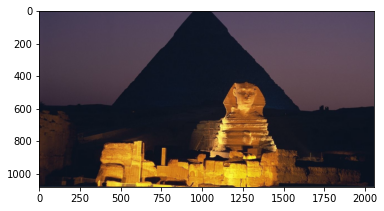

L-BFGS | iteration: 001, total loss=2851050356736.0000, content_loss=      0.0002, style loss=2851033680000.0000, tv loss=16881736.0000
L-BFGS | iteration: 002, total loss=2851047211008.0000, content_loss=      0.0158, style loss=2851030320000.0000, tv loss=16881776.0000
L-BFGS | iteration: 003, total loss=2851035938816.0000, content_loss=      0.2479, style loss=2851019040000.0000, tv loss=16881914.0000
L-BFGS | iteration: 004, total loss=2850967257088.0000, content_loss=      7.5101, style loss=2850950400000.0000, tv loss=16882728.0000
L-BFGS | iteration: 005, total loss=2850421997568.0000, content_loss=    426.3398, style loss=2850405120000.0000, tv loss=16889204.0000
L-BFGS | iteration: 006, total loss=2847573278720.0000, content_loss=  13167.2516, style loss=2847556320000.0000, tv loss=16922858.0000
L-BFGS | iteration: 007, total loss=2816772669440.0000, content_loss=1244110.5843, style loss=2816754000000.0000, tv loss=17292994.0000
L-BFGS | iteration: 008, total loss=266312666316

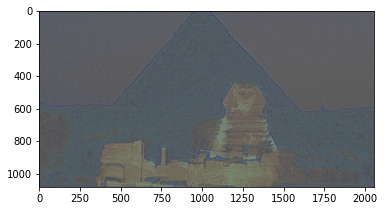

L-BFGS | iteration: 201, total loss=2789805824.0000, content_loss=655857177.7344, style loss=1825861523.4375, tv loss=308086976.0000
L-BFGS | iteration: 202, total loss=2521670656.0000, content_loss=658778564.4531, style loss=1555419726.5625, tv loss=307472448.0000
L-BFGS | iteration: 203, total loss=2540112128.0000, content_loss=657383203.1250, style loss=1575440273.4375, tv loss=307288576.0000
L-BFGS | iteration: 204, total loss=2473308416.0000, content_loss=658048925.7812, style loss=1507886132.8125, tv loss=307373248.0000
L-BFGS | iteration: 205, total loss=4711191040.0000, content_loss=661007763.6719, style loss=3738526640.6250, tv loss=311656608.0000
L-BFGS | iteration: 206, total loss=2446894848.0000, content_loss=657403662.1094, style loss=1481761289.0625, tv loss=307730016.0000
L-BFGS | iteration: 207, total loss=2688535552.0000, content_loss=654121875.0000, style loss=1725429960.9375, tv loss=308983936.0000
L-BFGS | iteration: 208, total loss=2404451328.0000, content_loss=655

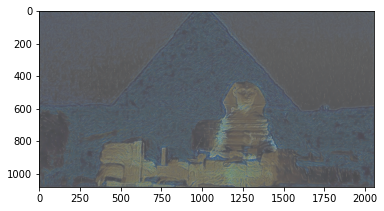

L-BFGS | iteration: 401, total loss=1237033472.0000, content_loss=549840625.0000, style loss=384512431.6406, tv loss=302680384.0000
L-BFGS | iteration: 402, total loss=1140636928.0000, content_loss=551839208.9844, style loss=285762978.5156, tv loss=303034752.0000
L-BFGS | iteration: 403, total loss=1157505664.0000, content_loss=549429248.0469, style loss=305437851.5625, tv loss=302638592.0000
L-BFGS | iteration: 404, total loss=1136062464.0000, content_loss=551036572.2656, style loss=282115048.8281, tv loss=302910816.0000
L-BFGS | iteration: 405, total loss=1170612864.0000, content_loss=548598486.3281, style loss=319344433.5938, tv loss=302669952.0000
L-BFGS | iteration: 406, total loss=1131753984.0000, content_loss=549858105.4688, style loss=279128613.2812, tv loss=302767232.0000
L-BFGS | iteration: 407, total loss=1156344448.0000, content_loss=548452685.5469, style loss=305326875.0000, tv loss=302564896.0000
L-BFGS | iteration: 408, total loss=1127864832.0000, content_loss=549426123.

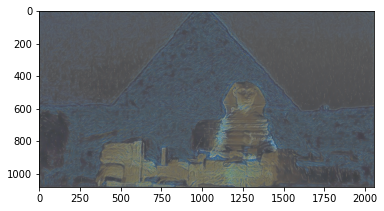

L-BFGS | iteration: 601, total loss=885304704.0000, content_loss=491347753.9062, style loss=109755073.2422, tv loss=284201888.0000
L-BFGS | iteration: 602, total loss=882609920.0000, content_loss=491902539.0625, style loss=106399233.3984, tv loss=284308128.0000
L-BFGS | iteration: 603, total loss=893904960.0000, content_loss=491269384.7656, style loss=119090815.4297, tv loss=283544768.0000
L-BFGS | iteration: 604, total loss=881304256.0000, content_loss=491510156.2500, style loss=105760041.5039, tv loss=284034048.0000
L-BFGS | iteration: 605, total loss=887922688.0000, content_loss=490048535.1562, style loss=114134758.3008, tv loss=283739424.0000
L-BFGS | iteration: 606, total loss=880066752.0000, content_loss=491059667.9688, style loss=105056088.8672, tv loss=283950976.0000
L-BFGS | iteration: 607, total loss=884346048.0000, content_loss=489691796.8750, style loss=111503869.6289, tv loss=283150400.0000
L-BFGS | iteration: 608, total loss=878473472.0000, content_loss=490397558.5938, st

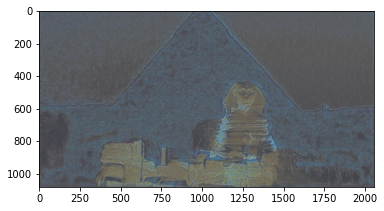

L-BFGS | iteration: 800, total loss=787333760.0000, content_loss=454667236.3281, style loss=69239135.7422, tv loss=263427376.0000


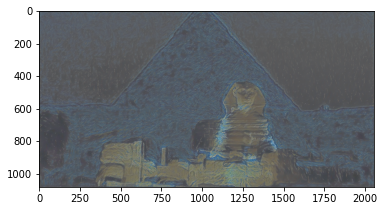

L-BFGS | iteration: 801, total loss=785258048.0000, content_loss=455029296.8750, style loss=66665917.9688, tv loss=263562816.0000
L-BFGS | iteration: 802, total loss=789222528.0000, content_loss=454668212.8906, style loss=71837395.0195, tv loss=262716928.0000
L-BFGS | iteration: 803, total loss=784689152.0000, content_loss=454802050.7812, style loss=66615461.4258, tv loss=263271616.0000
L-BFGS | iteration: 804, total loss=785340288.0000, content_loss=454486767.5781, style loss=67771040.0391, tv loss=263082464.0000
L-BFGS | iteration: 805, total loss=784067776.0000, content_loss=454644482.4219, style loss=66228537.5977, tv loss=263194768.0000
L-BFGS | iteration: 806, total loss=785864832.0000, content_loss=453870312.5000, style loss=69439160.1562, tv loss=262555392.0000
L-BFGS | iteration: 807, total loss=783552512.0000, content_loss=454289013.6719, style loss=66313059.0820, tv loss=262950464.0000
L-BFGS | iteration: 808, total loss=783843712.0000, content_loss=453954150.3906, style los

In [10]:
results_path = neural_style_transfer(config)

post-processing

In [11]:
#to zip all the files for download uncomment the next line of code
shutil.make_archive("Neural Style transfere complete0", 'zip', output_img_dir)

'/kaggle/working/Neural Style transfere complete0.zip'

In [12]:
#delete current output
#shutil.rmtree("./output-images")
#os.remove("./Neural Style transfere complete2.zip")

#memory cleaning
#import gc
#gc.collect()

#empty GPU memory
#torch.cuda.empty_cache()

# References and heavy influencers:
+ [A Neural Algorithm of Artistic Style (paper)](https://arxiv.org/abs/1508.06576)
+ [Image Style Transfer Using Convolutional Neural Networks (paper)](https://ieeexplore.ieee.org/document/7780634)
+ [Real-Time Neural Style Transfer for Videos (paper)(feedforward approach)](https://ieeexplore.ieee.org/document/8100228)
+ [TheAIEpiphany youtube channel](https://www.youtube.com/c/TheAIEpiphany)
+ [gordicaleksa's repo](https://github.com/gordicaleksa/pytorch-neural-style-transfer)
+ [Aladdin Persson youtube video](https://www.youtube.com/watch?v=imX4kSKDY7s&t=1236s)
+ [Tensorflow NST tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss)
